In [1]:
import math
import torch
import gpytorch
import cf_units
import datetime
import zarr
import dask

import dask.array as dsa
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

In [2]:
sea_level_picontrol = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol.zarr')
rechunked = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')
sea_level = sea_level_picontrol['sea_level']
general_map = sea_level_picontrol[dict(time=2000)]
pacific = general_map.sel(xt_ocean=slice(-120,-115), yt_ocean=slice(-10,-5.1))



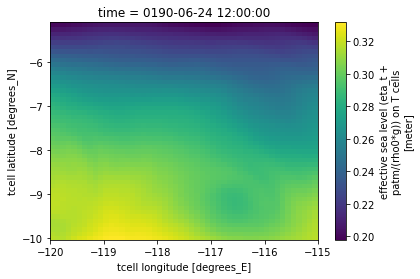

In [39]:
true_sealevel_slice = pacific['sea_level'].plot()

In [23]:
sea_information = pacific['sea_level'].to_pandas().stack().reset_index()

#Coordinates 
lat_long_torch = torch.tensor(np.vstack((sea_information['yt_ocean'], sea_information['xt_ocean'])).T)

def sea_array_appender(sea_info):
    sea_array = []
    for i in range(len(sea_info)):
        sea_array.append(sea_info[i])

    t_sea_array = torch.FloatTensor((np.array(sea_array)).astype(float) ).squeeze()
    
    return t_sea_array


#Sea values at coordinate locations
torch_sea_array = sea_array_appender(np.array(sea_information[0]))



# grid = torch.cat((x_y_array[:, 0].unique().unsqueeze(-1), x_y_array[:, 1].unique().unsqueeze(-1)),  -1)

tensor([0.3171, 0.3168, 0.3169,  ..., 0.1986, 0.1982, 0.1979])


In [21]:
x_train = lat_long_torch[0:1000].float()
y_train = torch_sea_array[0:1000]

x_train = torch.FloatTensor(x_train).squeeze()
y_train = torch.FloatTensor(y_train).squeeze()

# Calculate mean std of x and y variables
xtrain_mean = x_train.mean()
ytrain_mean = y_train.mean()

xtrain_std = x_train.std()
ytrain_std = y_train.std()

# Normalize training data
train_x = (x_train - x_train.mean()) / x_train.std()
train_y = (y_train - y_train.mean()) / y_train.std()

# y_train = y_train.reshape(len(y_train),1)


#Test
x_test = lat_long_array[1000:2000].float()
test_x = torch.FloatTensor(x_test).squeeze()


y_test = torch_sea_array[1000:2000].float()
test_y = torch.FloatTensor(y_test).squeeze()

# Normalize testing data
test_x = (test_x - xtrain_mean) / xtrain_std
test_y = (test_y - ytrain_mean) / ytrain_std


# Full prediction
full_x = torch.cat((x_train, test_x))

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)



torch.Size([1000, 2])
torch.Size([1000])
torch.Size([1000, 2])
torch.Size([1000])


In [7]:

# #Training Grid

# #X
# x_train_grid_bounds = [(0, 1), (0, 2)]


# x_train_grid_size = 20

# x_train_grid = torch.zeros(x_train_grid_size, len(x_train_grid_bounds))
# print("grid shape:", x_train_grid)

# for i in range(len(x_train_grid_bounds)):
    
#     x_train_grid_diff = float(x_train_grid_bounds[i][1] - x_train_grid_bounds[i][0]) / (x_train_grid_size - 2)
#     print(x_train_grid_diff)
#     x_train_grid[:, i] = torch.linspace(x_train_grid_bounds[i][0] - x_train_grid_diff, x_train_grid_bounds[i][1] + x_train_grid_diff, x_train_grid_size)
#     print(x_train_grid[:, i])
    
# train_x = gpytorch.utils.grid.create_data_from_grid(x_train_grid)

# #train grid starts off with a zeros organized by the length of the bounds (2), and how big you want the training grid size to be (20)
# #then it goes through an iteration of the len of the bounds (2), where it finds the difference between the the first grid bounds second entry and the first,
# #divided by the grid size - 2. So, 1/18 (this checks out). Then this difference is used to construct a new grid of entries, which starts at the difference 
# #between the first the first entry of the bounds minus the difference, ends at the addition of the second entry of the first grid bounts, and has a step size
# #in between of the grid size as well.


# #Y
# y_train_grid_bounds = [(0, 1), (0, 2)]

# y_train_grid_size = 20

# y_train_grid = torch.zeros(y_train_grid_size, len(y_train_grid_bounds))
# print("grid shape:", y_train_grid.shape)

# for i in range(len(y_train_grid_bounds)):
    
#     y_train_grid_diff = float(y_train_grid_bounds[i][1] - y_train_grid_bounds[i][0]) / (y_train_grid_size - 2)
#     y_train_grid[:, i] = torch.linspace(y_train_grid_bounds[i][0] - y_train_grid_diff, y_train_grid_bounds[i][1] + y_train_grid_diff, y_train_grid_size)
    
# unsqueezed_train_y = gpytorch.utils.grid.create_data_from_grid(y_train_grid)

# numpy_train_y = unsqueezed_train_y.numpy()
# print(numpy_train_y.shape)

# reshaped_numpy_train_y = numpy_train_y.reshape(400,1)
# print(reshaped_numpy_train_y.shape)

# train_y = torch.tensor(reshaped_numpy_train_y)
# print(train_y.dtype)
# print(train_x.shape)
# print(train_y.shape)

In [52]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(x_mean, x_covar)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


hypers = {
    'covar_module.base_kernel.lengthscale': torch.tensor(1.7),
}

model.initialize(**hypers)

print(
    model.covar_module.base_kernel.lengthscale.item(),
)


1.7000000476837158


In [53]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)

        
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()


Iter 1/50 - Loss: 1.390   lengthscale: 1.700   noise: 0.693
Iter 2/50 - Loss: 1.373   lengthscale: 1.619   noise: 0.744
Iter 3/50 - Loss: 1.362   lengthscale: 1.540   noise: 0.793
Iter 4/50 - Loss: 1.354   lengthscale: 1.462   noise: 0.832
Iter 5/50 - Loss: 1.344   lengthscale: 1.386   noise: 0.852
Iter 6/50 - Loss: 1.335   lengthscale: 1.311   noise: 0.851
Iter 7/50 - Loss: 1.317   lengthscale: 1.238   noise: 0.836
Iter 8/50 - Loss: 1.303   lengthscale: 1.167   noise: 0.810
Iter 9/50 - Loss: 1.280   lengthscale: 1.097   noise: 0.776
Iter 10/50 - Loss: 1.256   lengthscale: 1.030   noise: 0.739
Iter 11/50 - Loss: 1.231   lengthscale: 0.964   noise: 0.699
Iter 12/50 - Loss: 1.201   lengthscale: 0.900   noise: 0.657
Iter 13/50 - Loss: 1.171   lengthscale: 0.839   noise: 0.615
Iter 14/50 - Loss: 1.136   lengthscale: 0.779   noise: 0.573
Iter 15/50 - Loss: 1.098   lengthscale: 0.722   noise: 0.532
Iter 16/50 - Loss: 1.060   lengthscale: 0.668   noise: 0.493
Iter 17/50 - Loss: 1.027   length

In [54]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

n=1000
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    train_pred = model(train_x).mean.detach()
#     print(observed_pred.mean)

import matplotlib.pyplot as plt
%matplotlib inline

pred_labels = observed_pred.mean.view(n)

# Calc abosolute error
test_y_actual = test_y
delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()




torch.Size([1000])
torch.Size([1000])


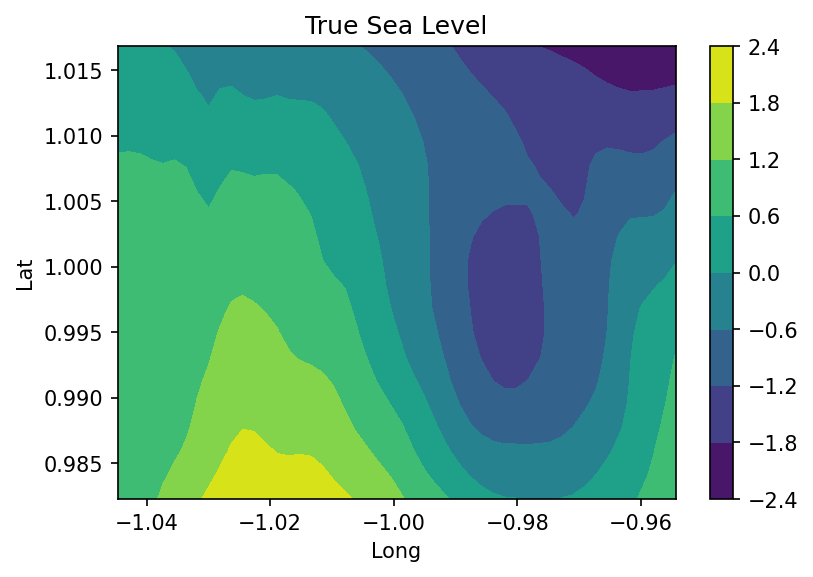

In [55]:
train_X_1, train_X_2 = np.meshgrid(train_x[:,1].unique(),train_x[:,0].unique())

print(train_x[:,1].shape)
print(test_x[:,1].shape)

plt.figure(dpi=150)
plt.contourf(train_X_1, train_X_2,
             train_y.reshape(train_X_2.shape))
plt.title("True Sea Level")
plt.xlabel("Long")
plt.ylabel("Lat")
plt.colorbar()
plt.show()

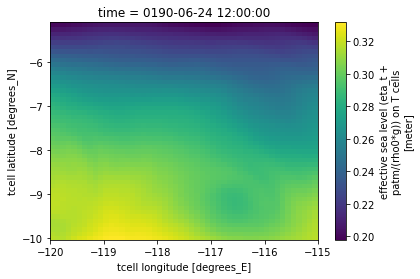

In [41]:
true_sealevel_slice = pacific['sea_level'].plot()

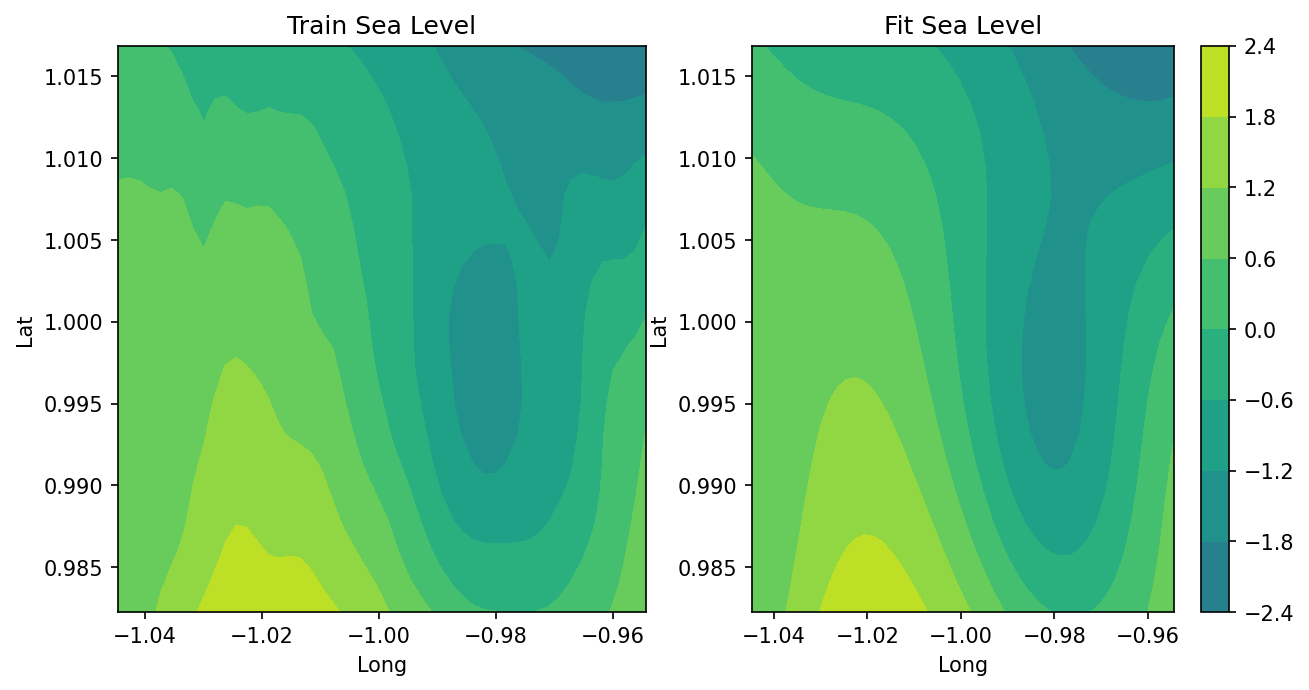

In [56]:
train_X_1, train_X_2 = np.meshgrid(train_x[:,1].unique(),train_x[:,0].unique())
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))

ax[0].contourf(train_X_1, train_X_2,
             train_y.reshape(train_X_2.shape), vmin=-6, vmax=3.)
ax[0].set_title("Train Sea Level")
ax[0].set_xlabel("Long")
ax[0].set_ylabel("Lat")

contour_ = ax[1].contourf(train_X_1, train_X_2,
             train_pred.reshape(train_X_2.shape), vmin=-6, vmax=3.)
ax[1].set_title("Fit Sea Level")
ax[1].set_xlabel("Long")
ax[1].set_ylabel("Lat")
fig.colorbar(contour_)
plt.show()

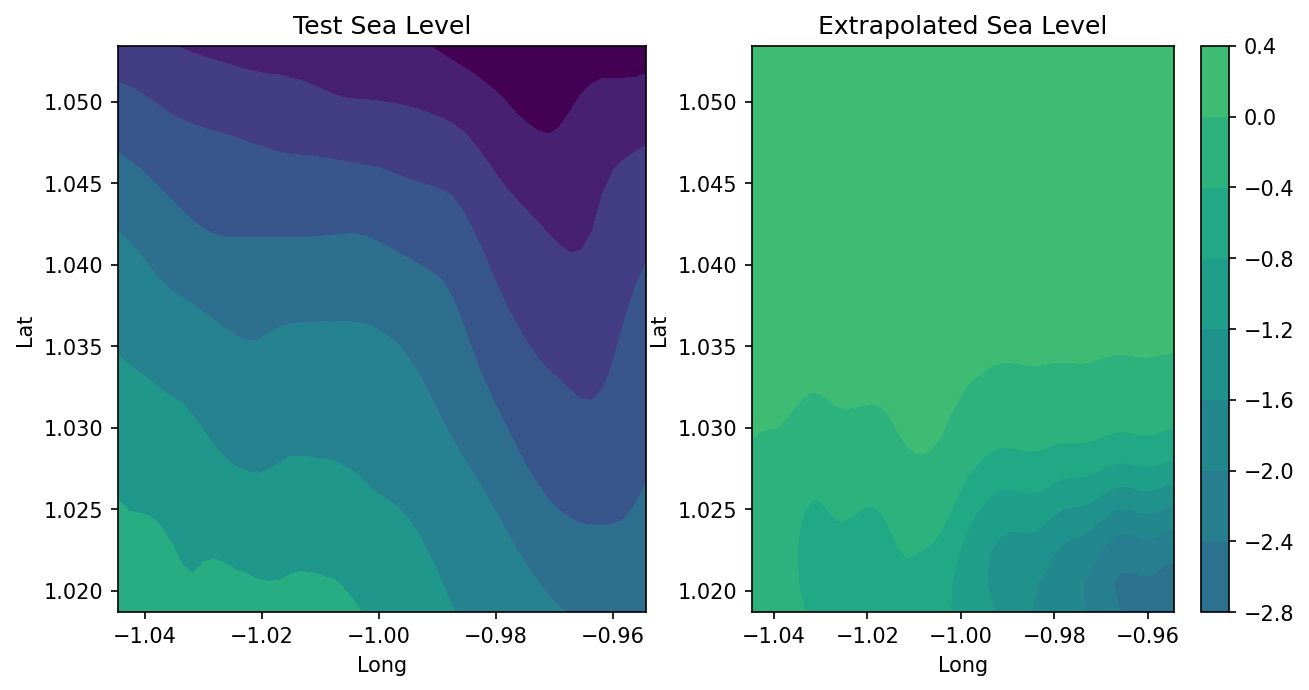

In [36]:
test_X_1, test_X_2 = np.meshgrid(test_x[:,1].unique(),test_x[:,0].unique())

fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))

ax[0].contourf(test_X_1, test_X_2,
             test_y.reshape(test_X_2.shape),vmin=-6, vmax=3.) 
ax[0].set_title("Test Sea Level")
ax[0].set_xlabel("Long")
ax[0].set_ylabel("Lat")

contour_ = ax[1].contourf(test_X_1, test_X_2,
             pred_labels.detach().reshape(test_X_2.shape),vmin=-6, vmax=3.)
ax[1].set_title("Extrapolated Sea Level")
ax[1].set_xlabel("Long")
ax[1].set_ylabel("Lat")
fig.colorbar(contour_)
plt.show()